# XAI Metrics based on Global Feature Importance

This tutorial explores the use of global feature importance for calculating explainability metrics. Both metrics and visualizations are presented in this guide. Criteria such as importance contraction and fluctuation of individual conditional expectation are metrics that help us understand the complexity of the relationship between the feature and the model's decision-making process.

In [1]:
from holisticai.utils import BinaryClassificationProxy
from sklearn.ensemble import RandomForestClassifier

from holisticai.datasets import load_dataset

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

from sklearn.pipeline import Pipeline

from holisticai.utils.inspection import compute_partial_dependence
from holisticai.utils.feature_importances import compute_permutation_feature_importance, compute_conditional_permutation_feature_importance
from holisticai.explainability.metrics import classification_global_feature_importance_explainability_metrics
from holisticai.utils.data_preprocessor import simple_preprocessor
from holisticai.efficacy.metrics import classification_efficacy_metrics

# Binary Classification (Adult Dataset)

In [2]:
dataset = load_dataset('adult', preprocessed=False)
dataset = dataset.train_test_split(test_size=0.5, random_state=42)
dataset

DatasetDict({
    train: <holisticai.datasets._dataset.Dataset object at 0x7f388bc8b4d0>,
    test: <holisticai.datasets._dataset.Dataset object at 0x7f388b71dc90>
})

In [3]:
train = dataset['train']
test = dataset['test']

Xt_train, Xt_test, yt_train, yt_test = simple_preprocessor(train['X'], test['X'], train['y'], test['y'])

**Define a Proxy Model**: A proxy model enables standardized use of your model across multiple functions. You simply provide the essential components required for each type of proxy. For instance, in binary classification, only the predict function, predict_proba function, and the labels are needed.

In [4]:
model = RandomForestClassifier(random_state=42)
model.fit(Xt_train, yt_train)

proxy = BinaryClassificationProxy(predict=model.predict, predict_proba=model.predict_proba, classes=model.classes_)
proxy

{"dtype":"Proxy Model","attributes":{"Learning Task":"binary_classification","Classes":[0,1]}}

# Efficacy Metrics

In [5]:
y_pred_test = proxy.predict(Xt_test)
efficacy_metrics = classification_efficacy_metrics(yt_test, y_pred_test)
efficacy_metrics

,Value,Reference
Metric,,
Accuracy,0.851532,1
Balanced Accuracy,0.775101,1
Precision,0.731450,1
Recall,0.624887,1
F1-Score,0.673983,1


# Global Explainable Features

Compute the permutation feature importance:

In [6]:
importances  = compute_permutation_feature_importance(X=Xt_test, y=yt_test, proxy=proxy)
importances

{"dtype":"Feature Importance","attributes":{"Number of Features":96,"Top 80% Features":10}}

Calculate the conditional feature importance for each label. For each label, select the samples associated with it and compute permutation feature importance on that subset.

In [7]:
conditional_feature_importances  = compute_conditional_permutation_feature_importance(X=Xt_test, y=yt_test, proxy=proxy)
conditional_feature_importances

{"dtype":"Conditional Feature Importance","attributes":{},"metadata":{},"nested_objects":[{"dtype":"Feature Importance","name":"Label: 0","attributes":{"Number of Features":96,"top 80% Features":18}},{"dtype":"Feature Importance","name":"Label: 1","attributes":{"Number of Features":96,"top 80% Features":20}}]}

Generate Partial Dependence Plots for the top 5 features with the highest importances.

In [8]:
top_n = 5
top_feature_names = importances.top_n(top_n).feature_names
partial_dependencies = compute_partial_dependence(Xt_test, features=top_feature_names, proxy=proxy)
partial_dependencies

{"dtype":"Partial Dependence","attributes":{"Number of Features":5,"Number of Labels":2,"Elements":["individual","average","grid_values"],"key":"[label_idx, feature_idx, element]"}}

You can plot manually the partial dependencies using the following code:

Text(0, 0.5, 'Partial Dependence')

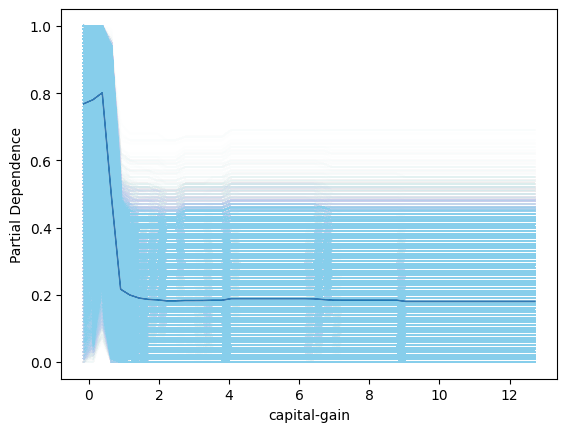

In [9]:
label_idx = 0
feature_idx = 0

average = partial_dependencies[label_idx,feature_idx,"average"]
grid_values = partial_dependencies[label_idx,feature_idx,"grid_values"]
individuals = partial_dependencies[label_idx,feature_idx,"individual"]

plt.plot(grid_values, average)
for ind in individuals:
    plt.plot(grid_values, ind, alpha=0.01, color='skyblue')
plt.xlabel(top_feature_names[feature_idx])
plt.ylabel('Partial Dependence')

# Global Feature Importance XAI Metrics

**Spread Divergence**: Measures how the feature importance values diverge from a uniform distribution. A high value indicates that the importance is concentrated on a few features.

**Fluctuation Ratio**: Measures the variability in model predictions when feature values are randomly permuted (using PDP). A high value indicates the model's sensitivity to that feature.

**Rank Alignment**: Assesses the consistency of feature importance rankings between categories 0 and 1. A high value means the feature importance is stable across these categories.

**Alpha Score**: Indicates the percentage of features with at least 80% of the maximum importance value. A high score suggests the model's focus on a select few features.

In [10]:
global_metrics = classification_global_feature_importance_explainability_metrics(partial_dependencies, importances, conditional_feature_importances,top_n=top_n)
global_metrics

,Value,Reference
Spread Divergence,0.731739,1
Fluctuation Ratio,0.117611,0
Rank Alignment,0.348485,1
Alpha Score,0.104167,0


plot_explainable_partial_dependence displays the PDP for the top 5 features, along with their 15 individual conditional expectation curves that exhibit the highest fluctuation ratios. The metric reflects the percentage of points where a change in the trend of the curve occurs. The intensity of the red color corresponds to the feature's importance.

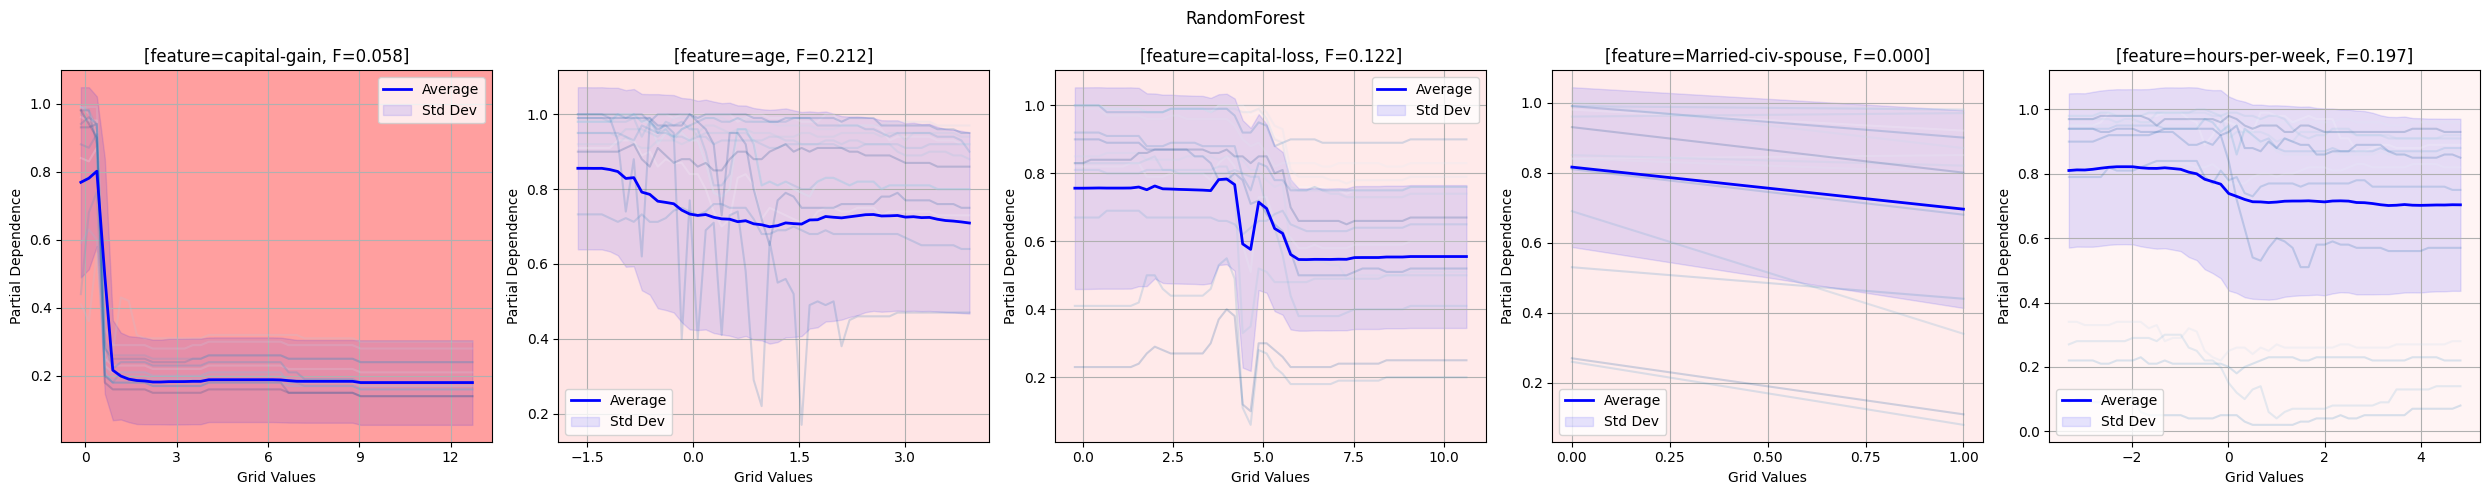

In [11]:
from holisticai.explainability.plots import plot_explainable_partial_dependence

partial_dependencies = compute_partial_dependence(Xt_test, features=top_feature_names, proxy=proxy)
plot_explainable_partial_dependence(partial_dependencies, 
                                    importances, 
                                    figsize=(25,5), 
                                    feature_names=partial_dependencies.feature_names, 
                                    model_name='RandomForest', 
                                    label=1, 
                                    top_n=5)

In [12]:
from holisticai.explainability.metrics.global_feature_importance import fluctuation_ratio

fr_df = fluctuation_ratio(partial_dependencies, importances, top_n=top_n, aggregated=False)
fr_df

,Fluctuation Ratio
capital-gain,0.057807
age,0.211981
capital-loss,0.121729
marital-status_Married-civ-spouse,0.000000
hours-per-week,0.196537


```plot_feature_importance``` displays the top feature importances and marks a horizontal line that separates the features contributing to at least the top 80% of the total importance.

<Axes: title={'center': 'Feature Importance'}, xlabel='Importance', ylabel='Features'>

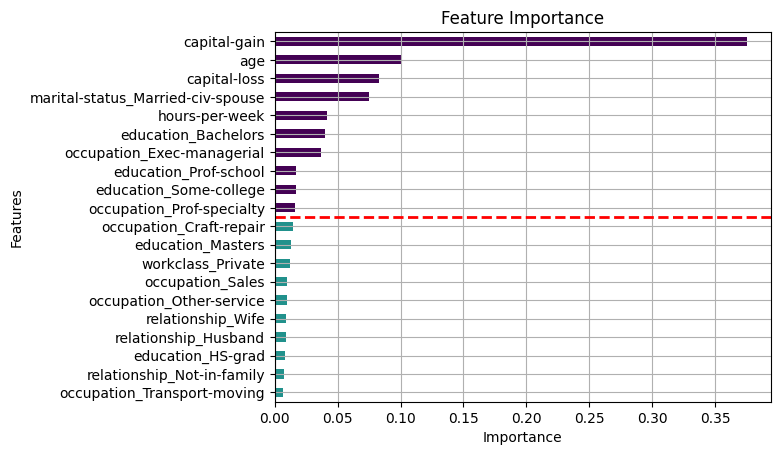

In [13]:
from holisticai.explainability.plots import plot_feature_importance
plot_feature_importance(importances, alpha=0.8, top_n=20)

The function ```plot_top_explainable_global_feature_importances``` visualizes the top feature importances alongside each feature's fluctuation ratio. Notably, the features "age" and "hours-per-week" exhibit fluctuations in approximately 20% of data points.

In [14]:
from holisticai.explainability.metrics.global_feature_importance import fluctuation_ratio

fr_df = fluctuation_ratio(partial_dependencies, importances, top_n=top_n, aggregated=False)
fr_df

,Fluctuation Ratio
capital-gain,0.057807
age,0.211981
capital-loss,0.121729
marital-status_Married-civ-spouse,0.000000
hours-per-week,0.196537


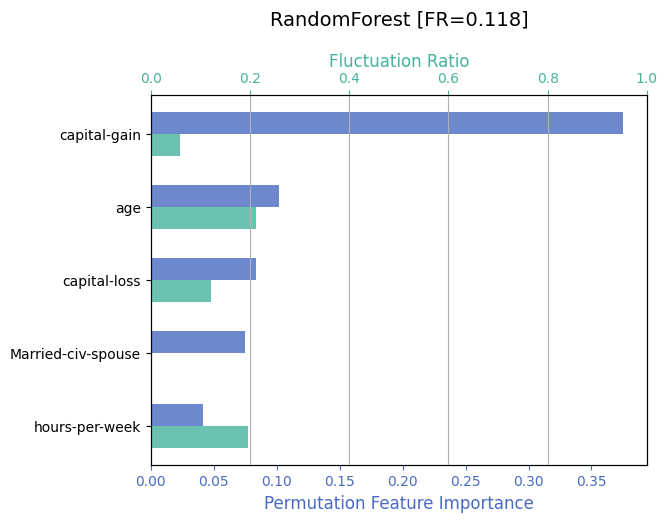

In [15]:
import importlib
import holisticai
importlib.reload(holisticai)
importlib.reload(holisticai.explainability.plots)

from holisticai.explainability.plots import plot_top_explainable_global_feature_importances
plot_top_explainable_global_feature_importances(partial_dependencies, 
                                                importances, 
                                                model_name="RandomForest", 
                                                top_n=top_n)

# Regression (US Crime Dataset)

load and preprocessing US Crime Dataset

In [16]:
ds = load_dataset('us_crime', preprocessed=False)
dataset = ds.train_test_split(test_size=0.2, random_state=42)

train = dataset['train']
test = dataset['test']

Xt_train, Xt_test, yt_train, yt_test = simple_preprocessor(train['X'], test['X'], train['y'], test['y'], categorical_types=['object'], model_type='regression', only_numerics=True)

Train the model and measure efficacy

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
from holisticai.utils import RegressionProxy
from holisticai.efficacy.metrics import regression_efficacy_metrics
from holisticai.utils import concatenate_metrics

model = GradientBoostingRegressor()
model.fit(Xt_train, yt_train)
proxy = RegressionProxy(predict=model.predict)

y_pred_test = model.predict(Xt_test)
efficacy_metrics =regression_efficacy_metrics(yt_test, y_pred_test)
efficacy_metrics

,Value,Reference
Metric,,
RMSE,1.383026e-01,0
MAE,8.913913e-02,0
MAPE,1.374844e+12,0
Max Error,7.582146e-01,0
SMAPE,2.346846e-01,0


Compute feature importance and partial dependence

In [18]:
importances  = compute_permutation_feature_importance(X=Xt_test, y=yt_test, proxy=proxy)

conditional_feature_importances  = compute_conditional_permutation_feature_importance(X=Xt_test, y=yt_test, proxy=proxy)

top_n = 5
top_feature_names = importances.top_n(top_n).feature_names
partial_dependencies = compute_partial_dependence(Xt_test, features=top_feature_names, proxy=proxy)

Compute Global Feature Importance XAI Metrics

In [19]:
global_metrics = classification_global_feature_importance_explainability_metrics(partial_dependencies, importances, conditional_feature_importances,top_n=top_n)
global_metrics

,Value,Reference
Spread Divergence,0.686133,1
Fluctuation Ratio,0.12388,0
Rank Alignment,0.272962,1
Alpha Score,0.138614,0


In [20]:
partial_dependencies

{"dtype":"Partial Dependence","attributes":{"Number of Features":5,"Number of Labels":1,"Elements":["individual","average","grid_values"],"key":"[label_idx, feature_idx, element]"}}

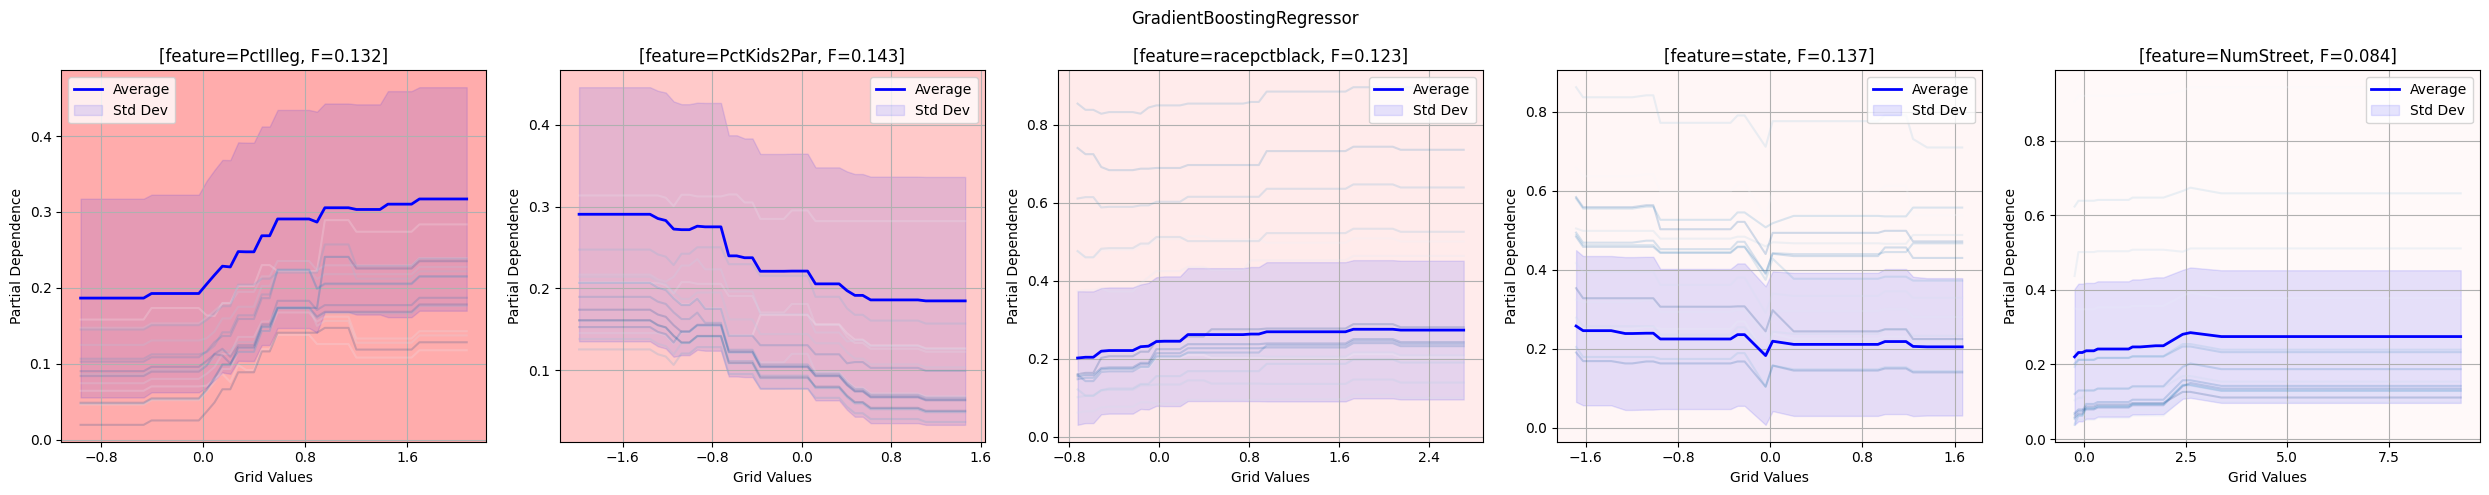

In [21]:
from holisticai.explainability.plots import plot_explainable_partial_dependence

plot_explainable_partial_dependence(partial_dependencies, 
                                    importances, 
                                    figsize=(25,5), 
                                    feature_names=partial_dependencies.feature_names, 
                                    model_name='GradientBoostingRegressor', 
                                    top_n=5)

<Axes: title={'center': 'Feature Importance'}, xlabel='Importance', ylabel='Features'>

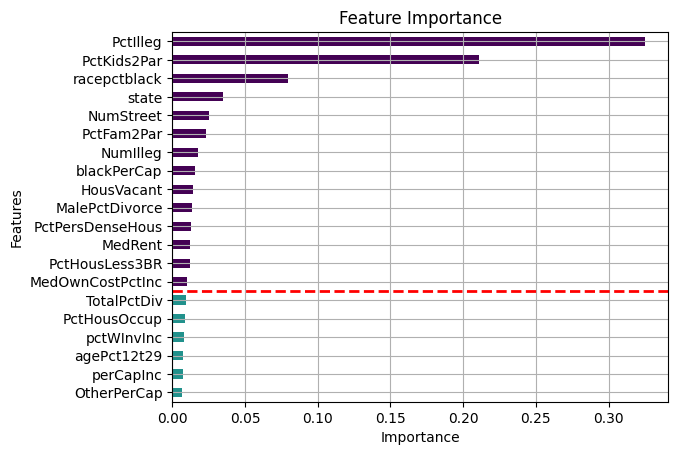

In [22]:
from holisticai.explainability.plots import plot_feature_importance
plot_feature_importance(importances, alpha=0.8, top_n=20)

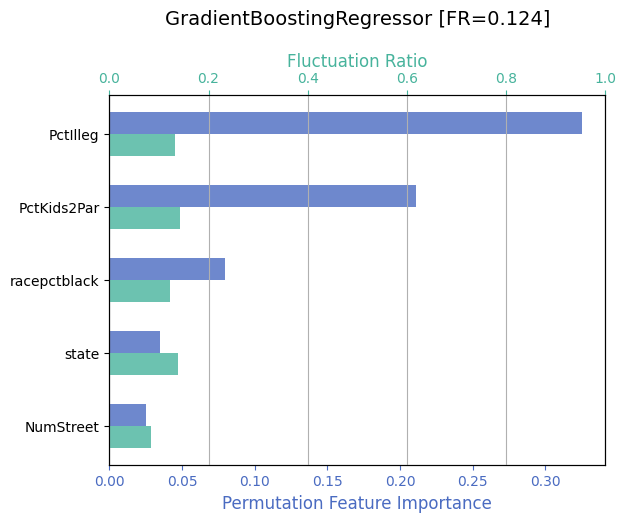

In [23]:
from holisticai.explainability.plots import plot_top_explainable_global_feature_importances
plot_top_explainable_global_feature_importances(partial_dependencies, 
                                                importances, 
                                                model_name="GradientBoostingRegressor", 
                                                top_n=top_n)